In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 33.5 MB/s 
     |████████████████████████████████| 209 kB 44.5 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 75.8 MB/s 
     |████████████████████████████████| 146 kB 67.3 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=806318832da5c1c0ef58842c34ff94b8fad27a2604692907221e1b7fdce1905c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 33.4 MB/s 
     |████████████████████████████████| 140 kB 96.0

In [57]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

logger = TensorBoardLogger('.', name = 'TFT')

from datetime import datetime

save_path = '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/'
datetime.today()
today = datetime.today()
str_today = today.strftime('%y%m%d%H%M')
save_model = save_path + str_today + '_TFT_key_saved_model.pth'
save_best_model = save_path + str_today + '_TFT_key_saved_best_model.pth'
print(save_model)
print(save_best_model)

/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206211839_TFT_key_saved_model.pth
/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206211839_TFT_key_saved_best_model.pth


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
drop_col = ['keyword','us_holiday', 'irr_cd91', 'irr_call', 'irr_govt03y', 'irr_corp03y', 'irr_cofixbal',
            'irr_cofixnew', 'ss_volume', 'hn_volume', 'nd_volume', 'amd_volume', 'topic_perc_contrib', 'oil_gsl', 'oil_hgsl', 'oil_lo' ]
data_t = data.drop(drop_col, axis=1)
# data['keyword'] = data['keyword'].str.replace("<"," ")
# data_t = data.copy()
data_t['date'] = pd.to_datetime(data_t['date'], format='%Y-%m-%d')
data_t = data_t.sort_values('date').reset_index(drop=True)
data_t['time_index'] = np.arange(len(data))
data_t['time_index'] = data_t['time_index'].astype(int)
# data_t['dominant_topic'] = data_t['dominant_topic'].astype(str).astype("category")
data_t['market'] = data_t['market'].astype(str).astype("category")

data_t['kr_holiday'] = data_t['kr_holiday'].apply(lambda x : x.replace('.',''))

holi_df = pd.get_dummies(data_t['kr_holiday'])
holi_df = holi_df.drop(columns='-')
kr_special_days = holi_df.columns.tolist()

holi_df[kr_special_days] = (
    holi_df[kr_special_days]
    .apply(lambda x: x.map({0: "-", 1: x.name}))
    .astype("category")
)


# kr_h_df = pd.get_dummies(res_data['kr_holiday'])
# kr_h_df = kr_h_df.drop(columns='-')
# kr_special_days = kr_h_df.columns.tolist()

# kr_h_df[kr_special_days] = (
#     kr_h_df[kr_special_days]
#     .apply(lambda x: x.map({0: "-", 1: x.name}))
#     .astype("category")
# )

res_data = pd.concat([data_t.drop(columns = 'kr_holiday'), holi_df], axis=1)
# res_data = pd.concat([res_data.drop(columns = 'kr_holiday'), kr_h_df], axis=1)

# target_col = ['trade_price']
# ord_col = data_t.dtypes.index[(data_t.dtypes.values != 'float64')].tolist()
# scale_col = data_t.columns[~data_t.columns.isin(ord_col) & ~data_t.columns.isin(target_col)].tolist()

# # MinMaxScaler
# scaler = MinMaxScaler()
# # scaler_t = MinMaxScaler(feature_range = (0,1))

# data_feature_scaled = scaler.fit_transform(data_t[scale_col])

# # data_target_scaled = scaler_t.fit_transform(data_t[target_col])


# data_f_scaled = pd.DataFrame(data_feature_scaled, columns=scale_col)
# data_t_scaled = pd.DataFrame(data_t['trade_price'], columns=target_col)
# res_data = pd.concat([data_f_scaled, data_t[ord_col], data_t['trade_price']], axis=1)




In [7]:
def objective(trial):

    cfg = { 'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0),
            'hidden_size' : trial.suggest_categorical('hidden_size', [16,32, 64,128,256,512,1024]),
            'hidden_continuous_size' : trial.suggest_categorical('hidden_continuous_size', [16,32,64,128,256,512,1024]),
            'attention_head_size' : trial.suggest_int('attention_head_size', 2, 7, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 1e-0),
             'dropout' : trial.suggest_categorical('dropout', [0,0.1,0.2])
        }

    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 60    # encoder LSTM에 들어가는 길이
    max_prediction_length = 20 # decoder의 길이


    output_size = 7
    log_interval = 10
    limit_train_batches = 50
    batch_size = 128
    gpus = 1
    max_epochs = 30
    reduce_on_plateau_patience = 4

    training_cutoff = res_data['time_index'].max() - max_prediction_length
    # training_cutoff = int(res_data['time_index'].max() * .7)


    training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        group_ids=["market"], 
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=['dayofweek', 'month', 'kr_special_days'],
        # categorical_encoders={'us_holiday': NaNLabelEncoder(add_nan=True)},       
        variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        time_varying_unknown_categoricals=[],     
        time_varying_unknown_reals=[
                    "trade_price",
                    # "avg_trade_price_by_dow",
                    # "avg_trade_price_mo",
                    # "prev_closing_price",
                    # "trade_price_log",
                    "ma5",
                    # "ma20",
                    # "ma60",
                    # "cmdt_c",
                    # "oil_cl",
                    # "cmdt_cc",
                    # "dominant_topic",
                    # "candle_acc_trade_volume",
                    "fx_usdkrw",
                    "fx_usdcny",
                    # "g_trends",
        ],
        target_normalizer=GroupNormalizer(
            groups=["market"], transformation="softplus"
        ),  
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
    
    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'Baseline SMAPE : {SMAPE()(baseline_predictions, actuals)}')


    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate = cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size = cfg['hidden_continuous_size'],
        dropout = cfg['dropout'],
        attention_head_size = cfg['attention_head_size'],
        output_size = output_size,  # 7 quantiles by default
        loss = QuantileLoss(),
        log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience = reduce_on_plateau_patience,
    )

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate


    trainer = pl.Trainer(
        max_epochs = max_epochs,
        gpus = gpus,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )

    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")        


    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    torch.save(best_model.state_dict(), save_model)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    # predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)
    predictions = best_model.predict(val_dataloader)

    # SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()
    # (actuals - predictions).abs().mean()

    return SMAPE()(predictions, actuals)

In [ ]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=25)


In [9]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_key_220622_01.pkl')

['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_key_220622_01.pkl']

In [25]:
# study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/DeepAR_optuna_pca_220614_01.pkl")
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_key_220622_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.09957671910524368
 Params: 
    learning_rate: 0.001472046764573504
    hidden_size: 64
    hidden_continuous_size: 32
    attention_head_size: 6
    gradient_clip_val: 0.0003245250702503594
    dropout: 0.2


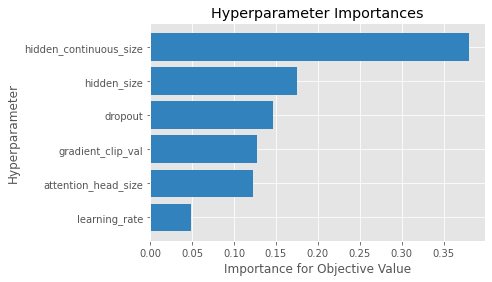

In [35]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

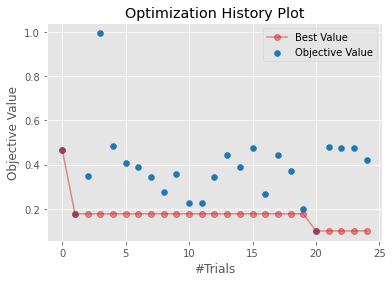



Number of finished trials:  25
Best trial:
  Value:  0.09957671910524368
  Params: 
    learning_rate: 0.001472046764573504
    hidden_size: 64
    hidden_continuous_size: 32
    attention_head_size: 6
    gradient_clip_val: 0.0003245250702503594
    dropout: 0.2


In [36]:
# show best hyperparameters
# print(study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")


print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [31]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 60    # encoder LSTM에 들어가는 길이
max_prediction_length = 20 # decoder의 길이


output_size = 7
log_interval = 10
limit_train_batches = 30
batch_size = 128
gpus = 1
max_epochs = 30
reduce_on_plateau_patience = 4

training_cutoff = res_data['time_index'].max() - max_prediction_length
# training_cutoff = int(res_data['time_index'].max() * .7)


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        group_ids=["market"], 
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=['dayofweek', 'month', 'kr_special_days'],
        # categorical_encoders={'us_holiday': NaNLabelEncoder(add_nan=True)},       
        variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        time_varying_unknown_categoricals=[],     
        time_varying_unknown_reals=[
                    "trade_price",
                    # "avg_trade_price_by_dow",
                    # "avg_trade_price_mo",
                    # "prev_closing_price",
                    # "trade_price_log",
                    "ma5",
                    # "ma20",
                    # "ma60",
                    # "cmdt_c",
                    # "oil_cl",
                    # "cmdt_cc",
                    # "dominant_topic",
                    # "candle_acc_trade_volume",
                    "fx_usdkrw",
                    "fx_usdcny",
                    # "g_trends",
        ],
        target_normalizer=GroupNormalizer(
            groups=["market"], transformation="softplus"
        ),  
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    dropout = study.best_params['dropout'],
    attention_head_size = study.best_params['attention_head_size'],
    output_size = output_size,  # 7 quantiles by default
    loss = QuantileLoss(),
    log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience = reduce_on_plateau_patience,
)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate


trainer = pl.Trainer(
    max_epochs = max_epochs,
    gpus = gpus,
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger = TensorBoardLogger('.', name = 'best_tft')
)

print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")        


# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


#### Evaluate performance

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

torch.save(best_model.state_dict(), save_best_model )

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions, _ = best_model.predict(val_dataloader, return_x=True)
# predictions = best_model.predict(val_dataloader)

SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()
print(f'SMAPE : {SMAPE}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 306   
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 20.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 43.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 14.9 K
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 285.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MAE : 318263.3125
SMAPE : 0.11365361511707306


In [37]:
actuals

tensor([[3038000., 3095000., 2884000., 2648000., 2694000., 2733000., 2806000.,
         2660000., 2695000., 2472000., 2583000., 2538000., 2552000., 2627000.,
         2533000., 2525000., 2494000., 2314000., 2225000., 2286000.]])

In [38]:
predictions

tensor([[2851828.2500, 2686722.0000, 2991604.5000, 3434183.2500, 2877536.0000,
         2687217.5000, 2700279.0000, 2781004.0000, 2638498.0000, 2934508.0000,
         3456254.0000, 2836033.5000, 2611402.0000, 2670784.5000, 2706220.0000,
         2591735.5000, 2877843.2500, 3472308.0000, 2803206.0000, 2553189.0000]])

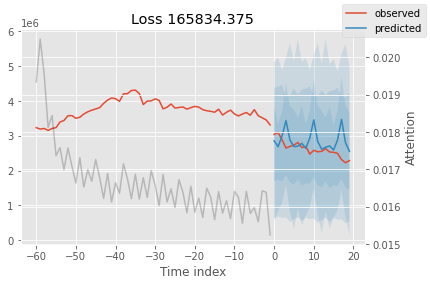

In [42]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

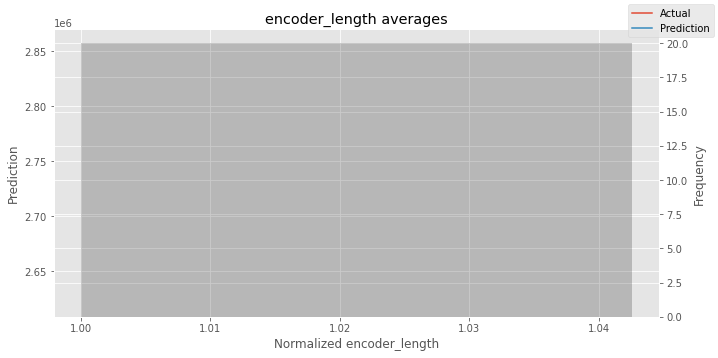

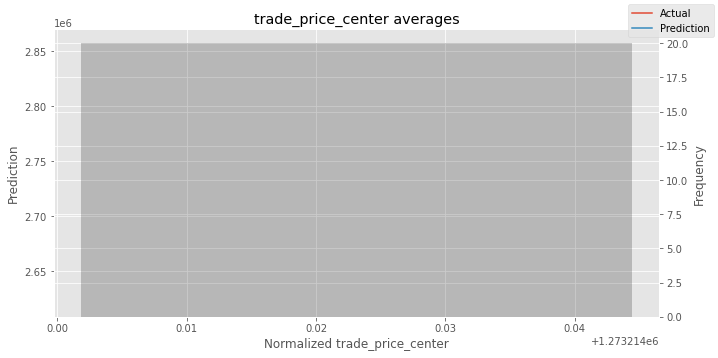

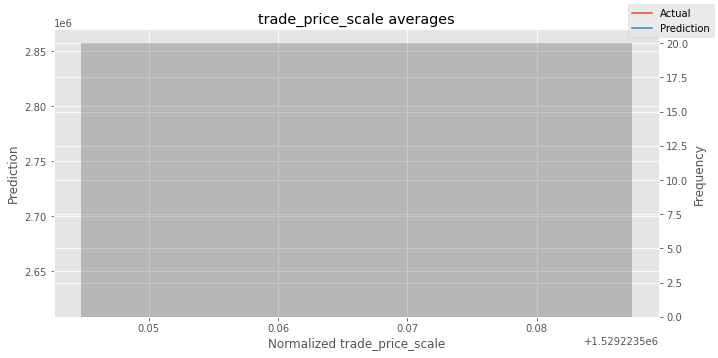

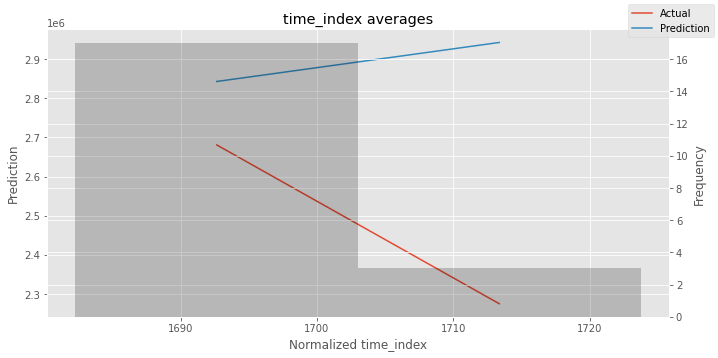

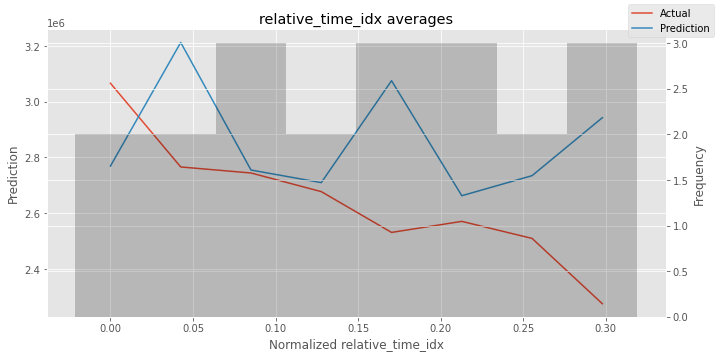

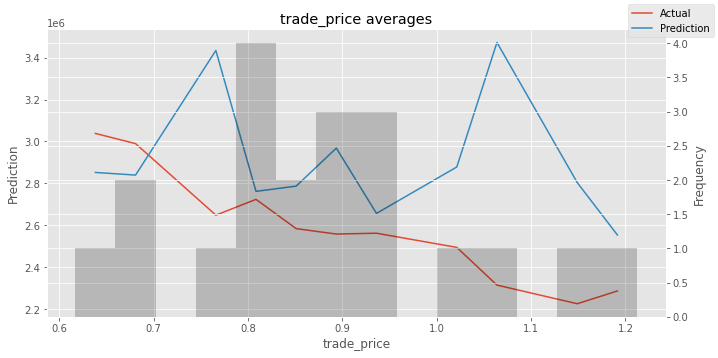

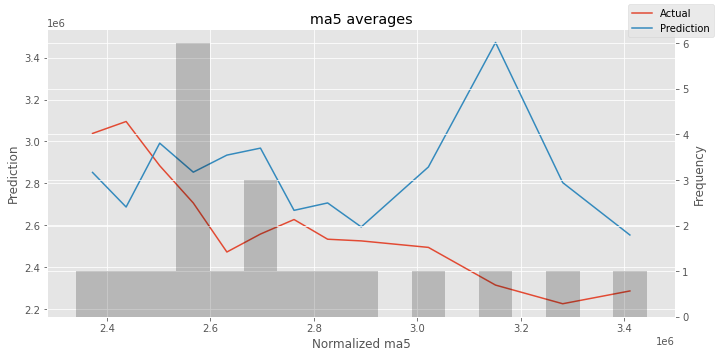

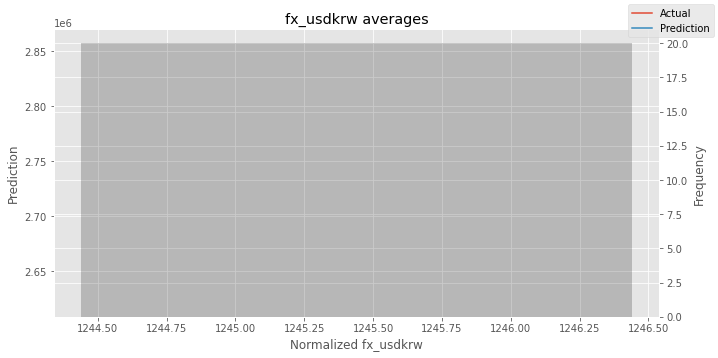

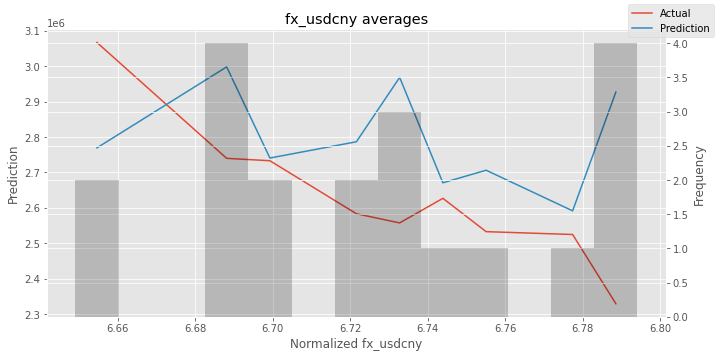

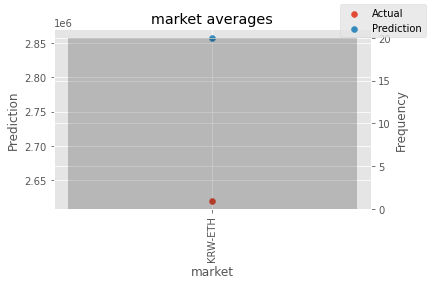

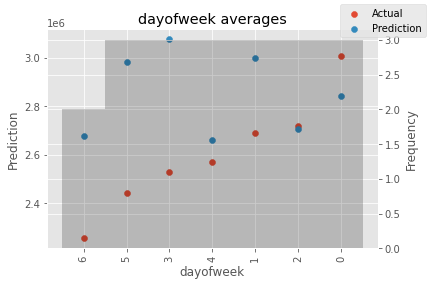

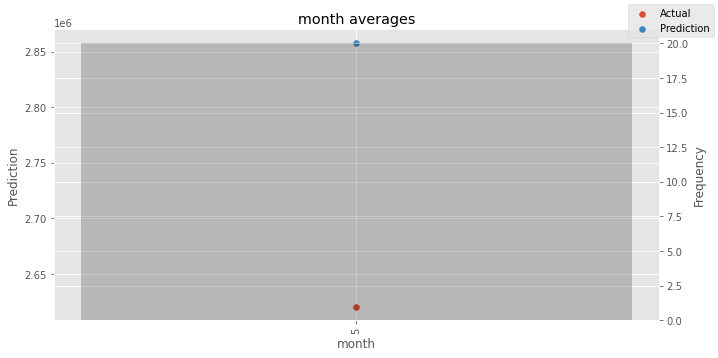

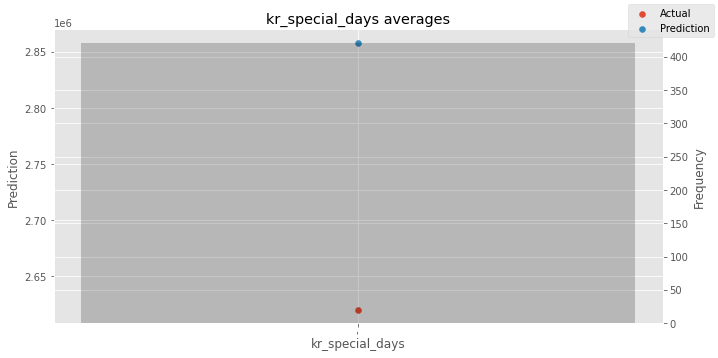

In [44]:
predictions, x = best_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_model.calculate_prediction_actual_by_variable(x, predictions)
best_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x306 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>}

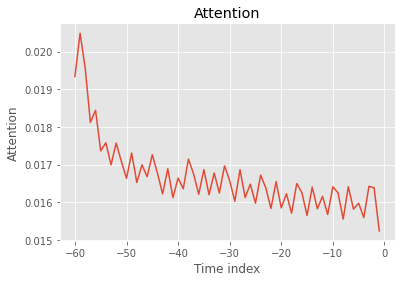

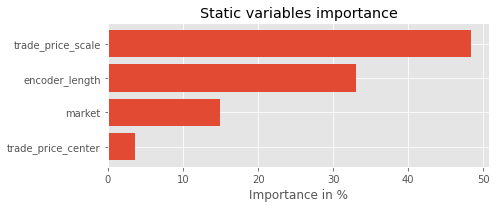

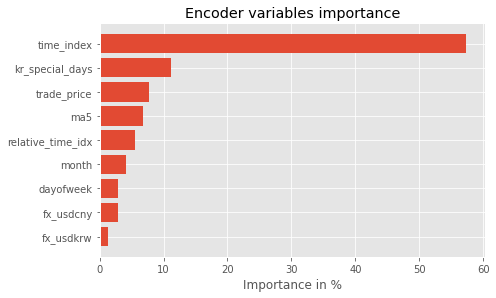

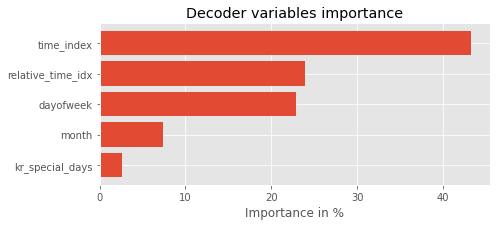

In [45]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

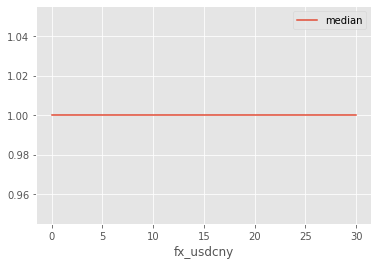

In [52]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "fx_usdcny", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("fx_usdcny").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

In [ ]:
# # best_load_model load

# best_load_model = TemporalFusionTransformer()
# best_load_model.load_state_dict(torch.load(save_best_model))
# best_load_model.eval()


# print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")


# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# raw_predictions, x = best_load_model.predict(val_dataloader, mode="raw", return_x=True)

# for idx in range(1):  # plot 10 examples
#     best_load_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# print(f'MAE : {(actuals - raw_predictions).abs().mean()}')

# SMAPE = (2 * (raw_predictions - actuals).abs() / (raw_predictions.abs() + actuals.abs() + 1e-8)).mean()
# print(f'SMAPE : {SMAPE}')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=best_tft/

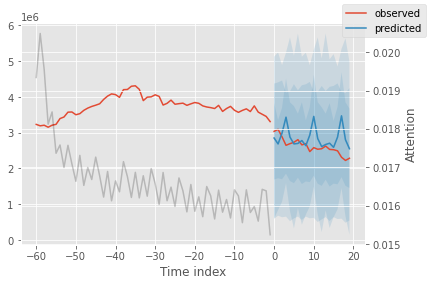

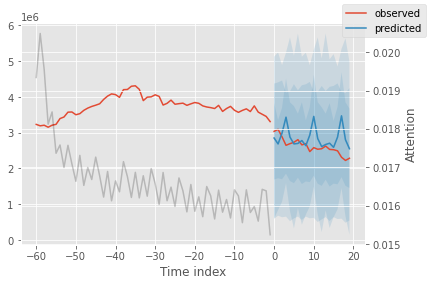

In [60]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)